# <center> Sequential MUD estimation - Monomial Test Case </center>

___
<font color='blue'><center>**Carlos del-Castillo-Negrete, Rylan Spence**</center></font>
    <br>
    <center>University of Texas at Austin
    <br>
    carlos.delcastillo@utexas.edu, rylan.spence@utexas.edu</center>
___

- [***Parameter Estimation with Maximal Updated Densities***](https://arxiv.org/pdf/2212.04587.pdf) Pilosov, M., del-Castillo-Negrete, C., Yen, T. Y., Butler, T., & Dawson, C. (2022). Parameter Estimation with Maximal Updated Densities. arXiv preprint arXiv:2212.04587.
___


<cite id="e9b62"><a href="#zotero%7C11450669%2F7F6J6S7U">(Wicks &#38; Atkinson, 2017)</a></cite>


____

Consider N-dimensional where each dimension is monomial with:
   
   $$ \Large \Lambda = [-1, 1] \in \mathbb{R} $$  
   
   $$ \Large Q_i(\lambda) = \lambda_i^p \rightarrow \mathcal{D} = [-1, 1] $$
   
for each dimension $i$ and an exponent $p$.

We assume:

   $\pi_{in} \sim \mathcal{U}([-1, 1])$
  
   $\pi_{ob} \sim \mathcal{N}(0.25,0.1^2)$

# Static Models

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (44182.8
Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (20203.6


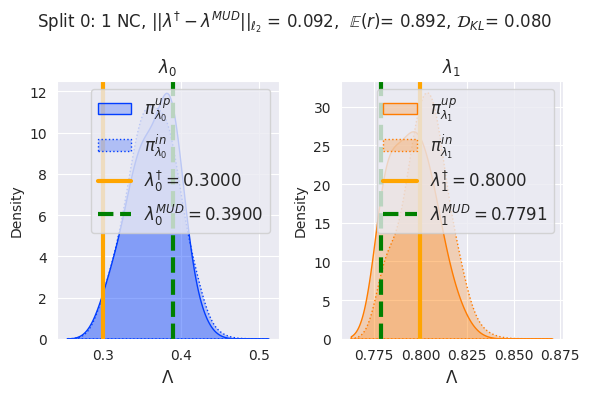

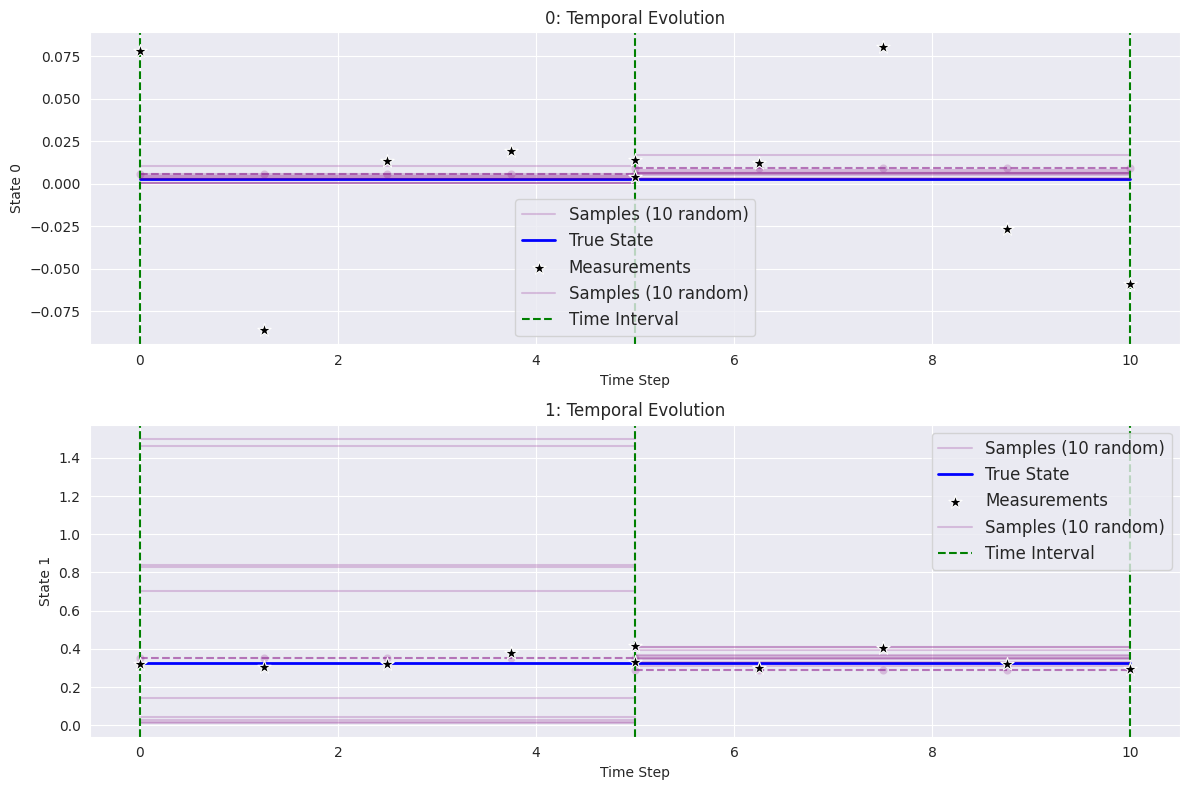

In [17]:
from pydci.examples.monomial import Monomial2D
        
mm2 = Monomial2D(5)
mm2.estimate_params([5, 10])
mm2.plot_states()

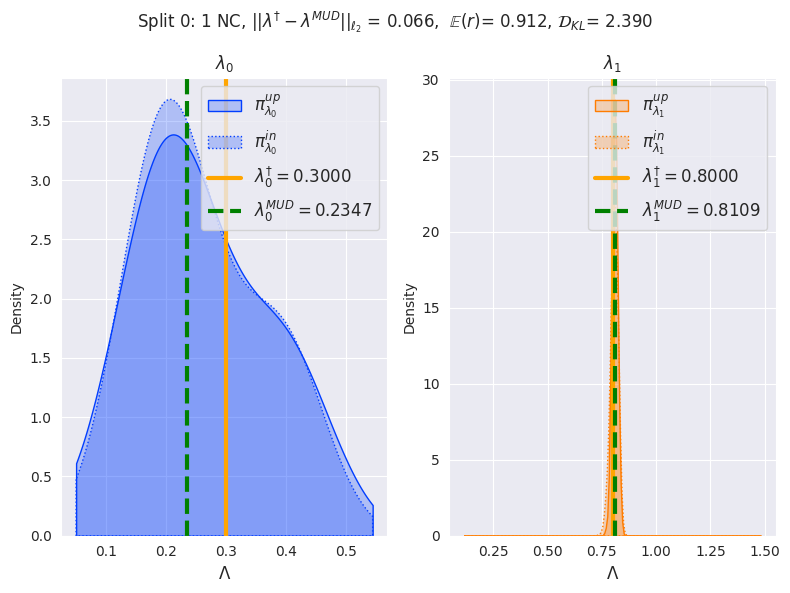

In [ ]:
mm2.probs[0].param_density_plots(lam_true=mm2.lam_true, base_size=6)

## Parameter estimation

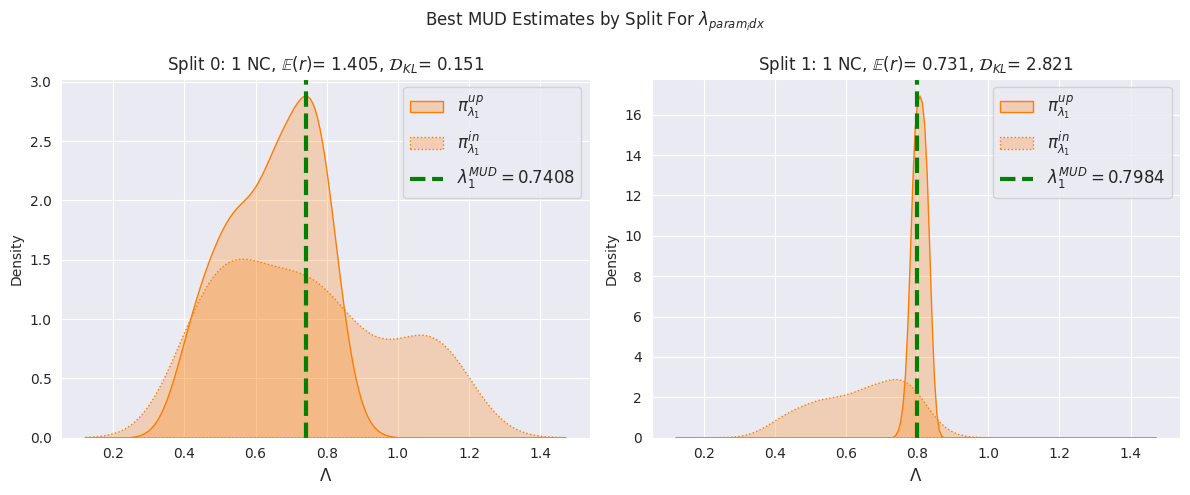

In [31]:
ss_prob.splits_param_density_plots(param_idx=1, figsize=(12,5))

In [17]:
ss_prob.split_results

e_r        kl  lam_MUD_0  lam_MUD_1  predict_delta  \
split nc qoi_comb                                                            
0     1  0         1.405363  0.150808   0.218980   0.740821       0.405363   
      2  0         0.358677  1.960680   0.411736   0.775167       0.641323   
1     1  0         0.731313  2.820506   0.246225   0.798390       0.268687   
      2  0         0.076744  3.248586   0.388268   0.811576       0.923256   

                   within_thresh  closest  max_kl  min_kl  
split nc qoi_comb                                          
0     1  0                  True     True    True    True  
      2  0                 False    False   False   False  
1     1  0                  True     True    True    True  
      2  0                 False    False   False   False

# Sequential Parameter Estimation - AKA Data Assimilation

Sequential (non-split) estimation where we can re-sample and assimilate observed data into our simulated samples between iterations.

TODO: Do this with new class that separates model and `SequentialProblem` class.

In [1]:
from pydci.log import logger, enable_log
from pydci import SplitSequentialProblem

enable_log()

from pydci import Model
import importlib
importlib.reload(Model)
import pdb
import numpy as np
import matplotlib.pyplot as plt

class Monomial2D(Model.DynamicModel):
    
    def __init__(self,
                 p,
                 x0=[0, 0], # Note in the constant monomial case, initial state won't matter
                 lam_true=[0.3, 0.8],
                 solve_ts=1.0,
                 sample_ts=1.1,
                 measurement_noise=0.05,
                 **kwargs
                ):
        self.p = p
        super().__init__(x0, lam_true,
                         solve_ts=solve_ts,
                         sample_ts=sample_ts,
                         measurement_noise=measurement_noise,
                         **kwargs)

        
    def forward_model(
        self,
        x0,
        times,
        lam,
    ):
        """
        Monomial Forward Model
        
        Static in time (tim array ignored)
        """
        res = np.repeat(np.array([[lam[0]**self.p, lam[1]**self.p]]), 1, axis=1)
        return res
    
    def plot_states(
        self,
        
    ):
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))
        for i, ax in enumerate(ax):
            self.plot_state(state_idx=i, ax=ax)
            ax.set_title(f'{i}: Temporal Evolution')
    
        
mm2 = Monomial2D(5)
lam = mm2.get_uniform_initial_samples(num_samples=100, scale=0.5)
args = mm2.forward_solve(5.0, samples=lam)

class SequentialProblem():
    
    def __init__(self, model):
        self.model = model
        self.probs = []
        
        
    def solve(
        self,
        time_windows,
        num_samples=100,
        diff=0.5,
        splits_per=1):        
        pi_in = None
        samples = self.model.get_uniform_initial_samples(num_samples=num_samples, scale=diff)
        for t in time_windows:
            logger.info(f'Starting iteration from {self.model.t0} to {t}')
            args = self.model.forward_solve(t, samples=samples)
            logger.info(f'Solving inverse problem')
            prob = SplitSequentialProblem(args['samples'], args['data'], args['std_dev'], pi_in=pi_in)
            prob.solve(num_splits=splits_per)
            logger.info(f'Drawing samples from updated distribution')
            samples = prob.sample_dist(num_samples=num_samples)
            self.probs.append(prob)
            

[04/14/23 17:07:30] INFO     Logger initialized                                                           ]8;id=599938;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=777126;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py#78\78]8;;\

                    INFO     Drawing 100 from uniform at:                                              ]8;id=775114;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=50215;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#242\242]8;;\
                                     loc: [0.15 0.4 ]                                                              
                                     scale: [0.3 0.8]                                                              

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (37564.7


In [ ]:
mm2 = Monomial2D(5)
time_windows = [5, 10, 15]
seq_prob = SequentialProblem(mm2)

seq_prob.solve(time_windows)

                    INFO     Drawing 100 from uniform at:                                              ]8;id=251698;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=924042;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#242\242]8;;\
                                     loc: [0.15 0.4 ]                                                              
                                     scale: [0.3 0.8]                                                              

                    INFO     Starting iteration from 0.0 to 5                                      ]8;id=638334;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=632493;file:///tmp/ipykernel_1785648/4009830505.py#76\76]8;;\

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (34279.0


                    INFO     Solving inverse problem                                               ]8;id=172052;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=191165;file:///tmp/ipykernel_1785648/4009830505.py#78\78]8;;\

                    INFO     Starting sequential algorithm with 1                     ]8;id=48128;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=637710;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#191\191]8;;\

                    INFO     Re-initializing problem with split #0                    ]8;id=45045;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=911787;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#193\193]8;;\

                    INFO     all: Trying 1 qoi combs.                                 ]8;id=989953;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=860151;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#207\207]8;;\

                    INFO     Trying comb of size 10: 1111111111                       ]8;id=1751;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=282681;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#210\210]8;;\

                    INFO     Solving using 1 components                                        ]8;id=773283;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=613539;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_in by computing KDE on lam                            ]8;id=99443;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=192294;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#189\189]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=348458;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=412705;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=538505;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=811687;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=322054;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=573675;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=932305;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=268934;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 1 components                                        ]8;id=540288;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=956727;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=774955;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=489960;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=529432;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=193792;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=939615;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=961710;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=935558;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=480926;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Drawing samples from updated distribution                             ]8;id=588109;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=229441;file:///tmp/ipykernel_1785648/4009830505.py#81\81]8;;\

                    INFO     Starting iteration from 5.0 to 10                                     ]8;id=448496;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=351776;file:///tmp/ipykernel_1785648/4009830505.py#76\76]8;;\

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (52740.2


                    INFO     Solving inverse problem                                               ]8;id=427782;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=904155;file:///tmp/ipykernel_1785648/4009830505.py#78\78]8;;\

                    INFO     Starting sequential algorithm with 1                     ]8;id=496446;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=388746;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#191\191]8;;\

                    INFO     Re-initializing problem with split #0                    ]8;id=769149;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=622031;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#193\193]8;;\

                    INFO     all: Trying 1 qoi combs.                                 ]8;id=275362;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=604733;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#207\207]8;;\

                    INFO     Trying comb of size 10: 1111111111                       ]8;id=130143;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=404692;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#210\210]8;;\

                    INFO     Solving using 1 components                                        ]8;id=618482;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=946105;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_in by computing KDE on lam                            ]8;id=562655;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=907678;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#189\189]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=786857;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=955923;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=615813;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=413153;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=841445;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=201406;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=620106;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=993753;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 1 components                                        ]8;id=125078;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=525501;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=9879;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=650475;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=36221;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=899227;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=516401;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=802956;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=173292;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=289097;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Drawing samples from updated distribution                             ]8;id=112838;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=965282;file:///tmp/ipykernel_1785648/4009830505.py#81\81]8;;\

                    INFO     Starting iteration from 10.0 to 15                                    ]8;id=298845;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=161876;file:///tmp/ipykernel_1785648/4009830505.py#76\76]8;;\

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (23655.9


                    INFO     Solving inverse problem                                               ]8;id=180504;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=886565;file:///tmp/ipykernel_1785648/4009830505.py#78\78]8;;\

                    INFO     Starting sequential algorithm with 1                     ]8;id=611545;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=366567;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#191\191]8;;\

                    INFO     Re-initializing problem with split #0                    ]8;id=520467;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=331334;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#193\193]8;;\

                    INFO     all: Trying 1 qoi combs.                                 ]8;id=590447;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=588155;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#207\207]8;;\

                    INFO     Trying comb of size 10: 1111111111                       ]8;id=307322;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=554865;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#210\210]8;;\

                    INFO     Solving using 1 components                                        ]8;id=964650;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=264950;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_in by computing KDE on lam                            ]8;id=430956;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=695623;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#189\189]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=237316;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=779013;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=972782;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=24624;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=556892;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=634619;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=559934;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=4786;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 1 components                                        ]8;id=912412;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=438574;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=715493;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=575935;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=445034;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=3859;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=404453;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=667018;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=624012;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=425478;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Drawing samples from updated distribution                             ]8;id=215105;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=570102;file:///tmp/ipykernel_1785648/4009830505.py#81\81]8;;\